# Sentiment Analysis

In [ ]:
# !pip install pandarallel
# !pip install nltk
# !pip install spacy
# !python3 -m spacy download en_core_web_md
# nltk.download('punkt')
# !pip install matplotlib

In [1]:
import pandas as pd
import pandarallel
import multiprocessing
import warnings
import re
import string
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', 5000)
warnings.filterwarnings("ignore")

In [3]:
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Using {workers} workers')
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Using 63 workers
INFO: Pandarallel will run on 63 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
import spacy
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])

In [5]:
import os
from IPython.display import clear_output
import requests
import pprint
from joblib import dump, load

In [6]:
df_sample = pd.read_csv('./cleaned_tokenized_output_final.csv')

In [7]:
df_sample = df_sample.reset_index(drop = True)

In [8]:
def bert_input_text(text):
    
    """
    Sentence Tokenize
    filter for more than 5 words
    filter for less than 50 words
    combine top 10 sentences
    """

    sent_tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
    tokens = sent_tokenizer.tokenize(text)
    # tokens = re.split(r"[.|]\s*", text)
    l1 = []
    l2 = []
    for i,j in enumerate(tokens):
        if ( (len(j.split()) < 50) and (len(j.split()) > 5) ):
            l1.append(str(j))
    
    if len(l1) >= 10:
        l2 = l1[1:10]
    else:
        l2 = l1[1:]
    
    return l2

In [9]:
%%time
df_sample['bert_text'] = df_sample['clean_text'].parallel_apply(bert_input_text)

CPU times: user 2.21 s, sys: 4.8 s, total: 7.01 s
Wall time: 10.7 s


In [10]:
def tokens_to_text2(tokens):
    
    new_text = " ".join(tokens[0:5])
    
    return new_text

In [11]:
%%time
df_sample['bert_combined'] = df_sample['bert_text'].parallel_apply(tokens_to_text2)

CPU times: user 847 ms, sys: 3.53 s, total: 4.38 s
Wall time: 4.96 s


In [12]:
print(df_sample.shape)
df_sample.head(2)

(181646, 9)


Unnamed: 0   
0           0  \
1           1   

                                                                                                                                        url   
0                                                                                      http://en.people.cn/n3/2021/0318/c90000-9830122.html  \
1  http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/   

         date   
0  2021-03-18  \
1  2020-02-27   

                                                                                                          clean_title   
0                                      Artificial improves parking efficiency in Chinese cities People s Daily Online  \
1  Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [13]:
df_sample_exp = df_sample.explode('bert_text')

In [14]:
df_sample_exp.dropna(subset=['bert_text'], inplace = True)

In [15]:
print(df_sample_exp.shape)
df_sample_exp.head(2)

(1463693, 9)


Unnamed: 0                                                   url   
0           0  http://en.people.cn/n3/2021/0318/c90000-9830122.html  \
0           0  http://en.people.cn/n3/2021/0318/c90000-9830122.html   

         date   
0  2021-03-18  \
0  2021-03-18   

                                                                      clean_title   
0  Artificial improves parking efficiency in Chinese cities People s Daily Online  \
0  Artificial improves parking efficiency in Chinese cities People s Daily Online   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

#### Write to a csv file

In [16]:
df_sample_exp.loc[:,['bert_text']].to_csv('df_sample_bert_input.csv', index=False)

#### Building custom model on open-source data (i.e. Yelp)

In [17]:
!pwd

/home/jupyter


In [18]:
def get_gcs_data (bucket_name, folder_name, file_name, path_local):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_local + '/' + file_name , 'wb').write(r.content)

In [19]:
path_yelp_data = '/home/jupyter/yelp'
#path_yelp_model = '/home/jupyter/data/yelp/yelp_model/'
#path_yelp_model = '/Users/preetikaparashar/Desktop/UChicago MSCA/Q3/NLP/4/data/yelp/yelp_model'
path_yelp_model = '/home/jupyter/data/yelp/yelp_model'
os.makedirs(path_yelp_data, exist_ok=True)
os.makedirs(path_yelp_model, exist_ok=True)

In [20]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'yelp/yelp_model'
file_name = ['model.joblib', 
             'nb.joblib', 'logreg.joblib', 'svm.joblib',
             # 'nb_small.joblib', 'logreg_small.joblib', 'svm_small.joblib'
            ]
path_local = path_yelp_model

os.makedirs(path_local, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_local = path_local)
    print('Downloaded: ' + file)

Downloaded: model.joblib
Downloaded: nb.joblib
Downloaded: logreg.joblib
Downloaded: svm.joblib


In [21]:
!ls -l /home/jupyter/data/yelp/yelp_model/
#!ls -l /Users/preetikaparashar/Desktop/UChicago MSCA/Q3/NLP/4/data/yelp/yelp_model
#!ls -ltr /home/jupyter

total 1874908
-rw-r--r-- 1 jupyter jupyter 522995808 May 27 01:00 logreg.joblib
-rw-r--r-- 1 jupyter jupyter   7420344 May 27 00:19 logreg_small.joblib
-rw-r--r-- 1 jupyter jupyter   7661465 May 27 01:00 model.joblib
-rw-r--r-- 1 jupyter jupyter 839186606 May 27 01:00 nb.joblib
-rw-r--r-- 1 jupyter jupyter  12203294 May 27 00:19 nb_small.joblib
-rw-r--r-- 1 jupyter jupyter 522996092 May 27 01:00 svm.joblib
-rw-r--r-- 1 jupyter jupyter   7420628 May 27 00:19 svm_small.joblib


In [22]:
# Logistic Regression large
%time clf_large = load(os.path.join(path_yelp_model, 'logreg.joblib'))

CPU times: user 41.6 s, sys: 2.43 s, total: 44 s
Wall time: 42.9 s


In [23]:
df_sample = pd.read_csv('df_sample_bert_input.csv')

In [24]:
df_sample.shape

(1463693, 1)

In [25]:
df_sample.head()

,bert_text
0,"This road used to be full of cars, and even the normal lanes were occupied."
1,"You could hardly move a bit during the morning and evening commute time, recalled a citizen surnamed Wang, who lives in Chaoyang district of Beijing."
2,"Since the summer of , roadside ETC devices have been installed here."
3,There are many in traditional parking systems.
4,"For example, magnetic devices cannot identify detailed information about vehicles each video monitoring pile can only cover one parking spot and manual collection of parking fees costs too much.Such problems don t exist in smart machines."


In [26]:
df_sample.isnull().sum()

bert_text    0
dtype: int64

In [27]:
X_test = df_sample['bert_text']

In [28]:
y_pred = clf_large.predict(X_test)

In [29]:
df_sample['sentiment'] = y_pred

In [30]:
df_sample.head()

,bert_text,sentiment
0,"This road used to be full of cars, and even the normal lanes were occupied.",0
1,"You could hardly move a bit during the morning and evening commute time, recalled a citizen surnamed Wang, who lives in Chaoyang district of Beijing.",0
2,"Since the summer of , roadside ETC devices have been installed here.",1
3,There are many in traditional parking systems.,1
4,"For example, magnetic devices cannot identify detailed information about vehicles each video monitoring pile can only cover one parking spot and manual collection of parking fees costs too much.Such problems don t exist in smart machines.",0


In [31]:
df_sample['sentiment'].value_counts()

sentiment
0    1018106
1     445587
Name: count, dtype: int64

In [32]:
df_sample['sentiment'].to_csv('text_sent_df.csv', index=False)

#### Read file in a dataframe

In [33]:
df_sent = pd.read_csv('text_sent_df.csv')

In [34]:
df_sample_exp.shape

(1463693, 9)

In [35]:
df_sample.shape

(1463693, 2)

In [36]:
df_sample_exp = df_sample_exp.reset_index().join(df_sent)

In [37]:
df_sample_exp.head(1)

index  Unnamed: 0                                                   url   
0      0           0  http://en.people.cn/n3/2021/0318/c90000-9830122.html  \

         date   
0  2021-03-18  \

                                                                      clean_title   
0  Artificial improves parking efficiency in Chinese cities People s Daily Online  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

#### Aggregate sentiment calculation

In [38]:
df_sample_recombined = df_sample_exp.groupby('index').agg({'url': 'first',
                                  'date': 'first',
                                  'clean_title': 'first',
                                  'clean_text': 'first',
                                  'tokens': 'first',
                                  'token_text': 'first',
                                  'bert_combined': 'first',
                                  'sentiment': 'mean'}).reset_index(drop = True)

In [39]:
df_sample_recombined.shape

(177091, 8)

In [40]:
df_sample_recombined.to_csv('df_news_with_sent.csv', index=False)

In [41]:
df_sample_recombined['token_text'].to_csv('df_news_topic.csv', index=False)

In [42]:
df_sample_recombined['clean_text'].to_csv('df_news_NER.csv', index=False)

In [43]:
df_sample_recombined.head(2)

url   
0                                                                                      http://en.people.cn/n3/2021/0318/c90000-9830122.html  \
1  http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/   

         date   
0  2021-03-18  \
1  2020-02-27   

                                                                                                          clean_title   
0                                      Artificial improves parking efficiency in Chinese cities People s Daily Online  \
1  Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

<AxesSubplot: >

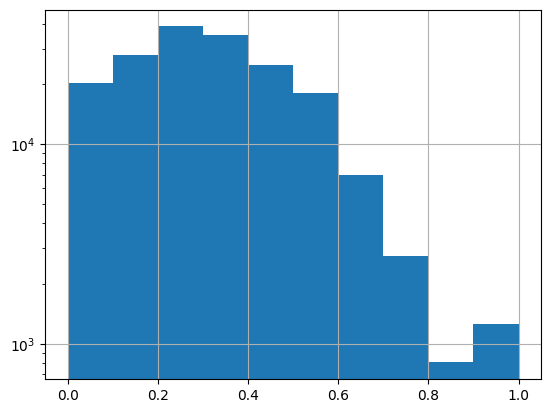

In [44]:
df_sample_recombined['sentiment'].hist(bins=10, log = True)

In [45]:
df_sample_recombined.head(1)

url        date   
0  http://en.people.cn/n3/2021/0318/c90000-9830122.html  2021-03-18  \

                                                                      clean_title   
0  Artificial improves parking efficiency in Chinese cities People s Daily Online  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Analyzing sentiment

In [46]:
news_timeline_df = df_sample_recombined.copy()[['date', 'sentiment']].set_index('date')

In [47]:
news_timeline_df['month'] = pd.to_datetime(news_timeline_df.index).month
news_timeline_df['year'] = pd.to_datetime(news_timeline_df.index).year

<AxesSubplot: xlabel='month', ylabel='sentiment'>

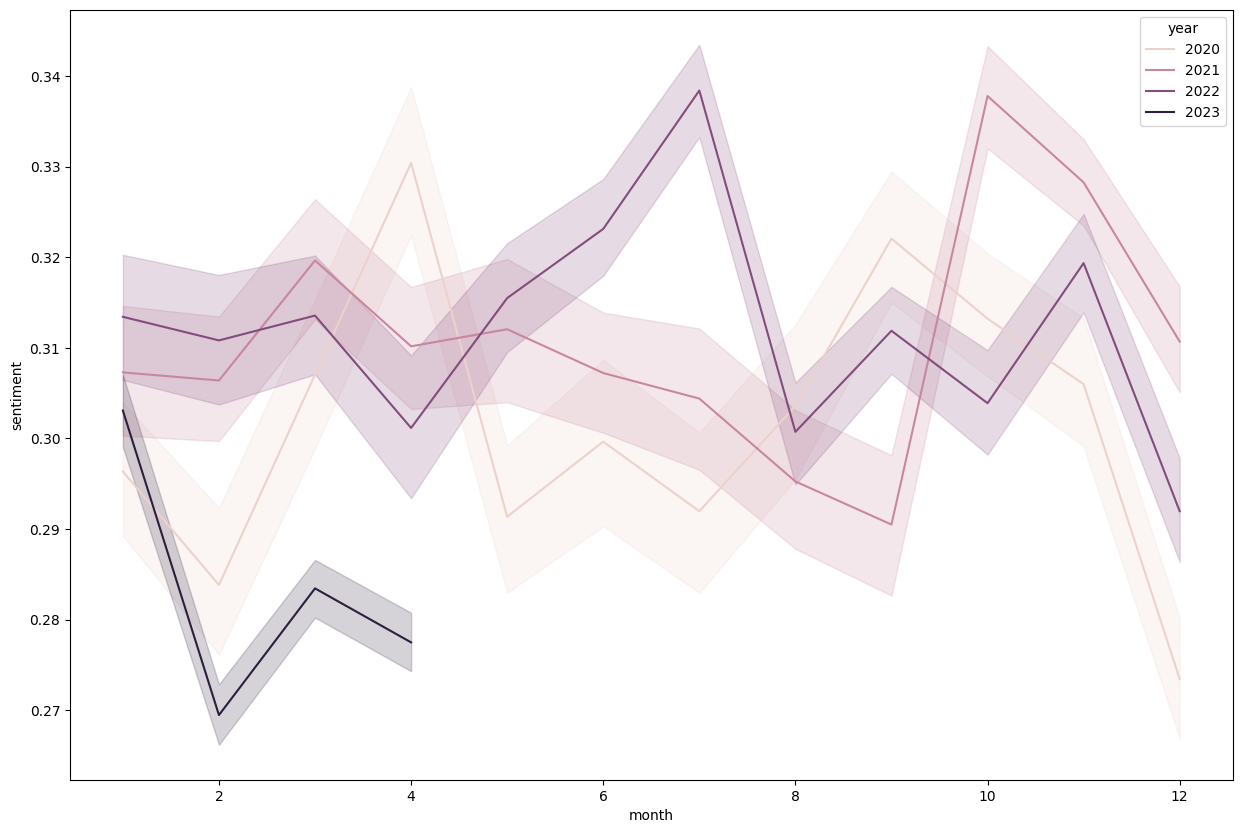

In [49]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,10)
sns.lineplot(x='month',y='sentiment',hue='year',data=news_timeline_df)

In [50]:
pos_text2 = " ".join(df_sample_recombined[df_sample_recombined['sentiment']==1]['bert_combined'].tolist())

In [51]:
neg_text2 = " ".join(df_sample_recombined[df_sample_recombined['sentiment']==0]['bert_combined'].tolist())

In [52]:
import wordcloud

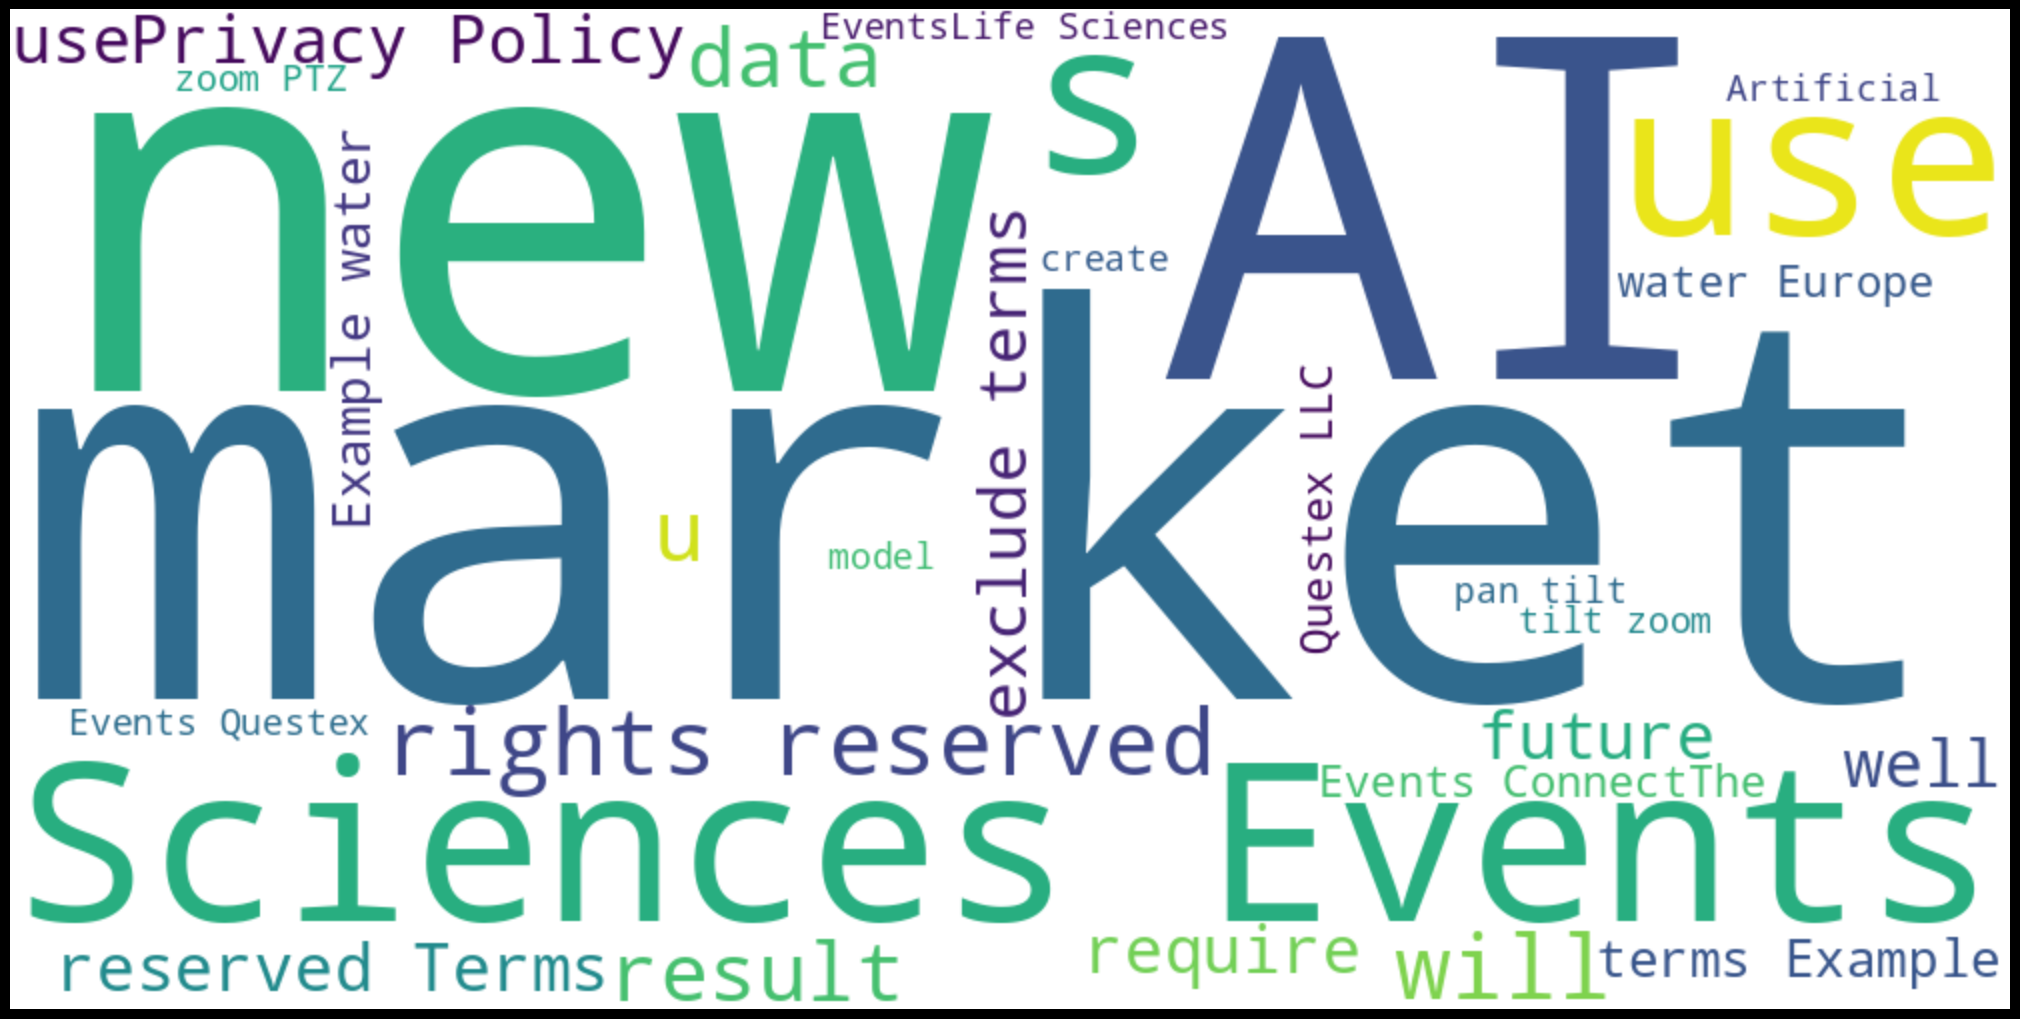

In [54]:
wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate(pos_text2)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

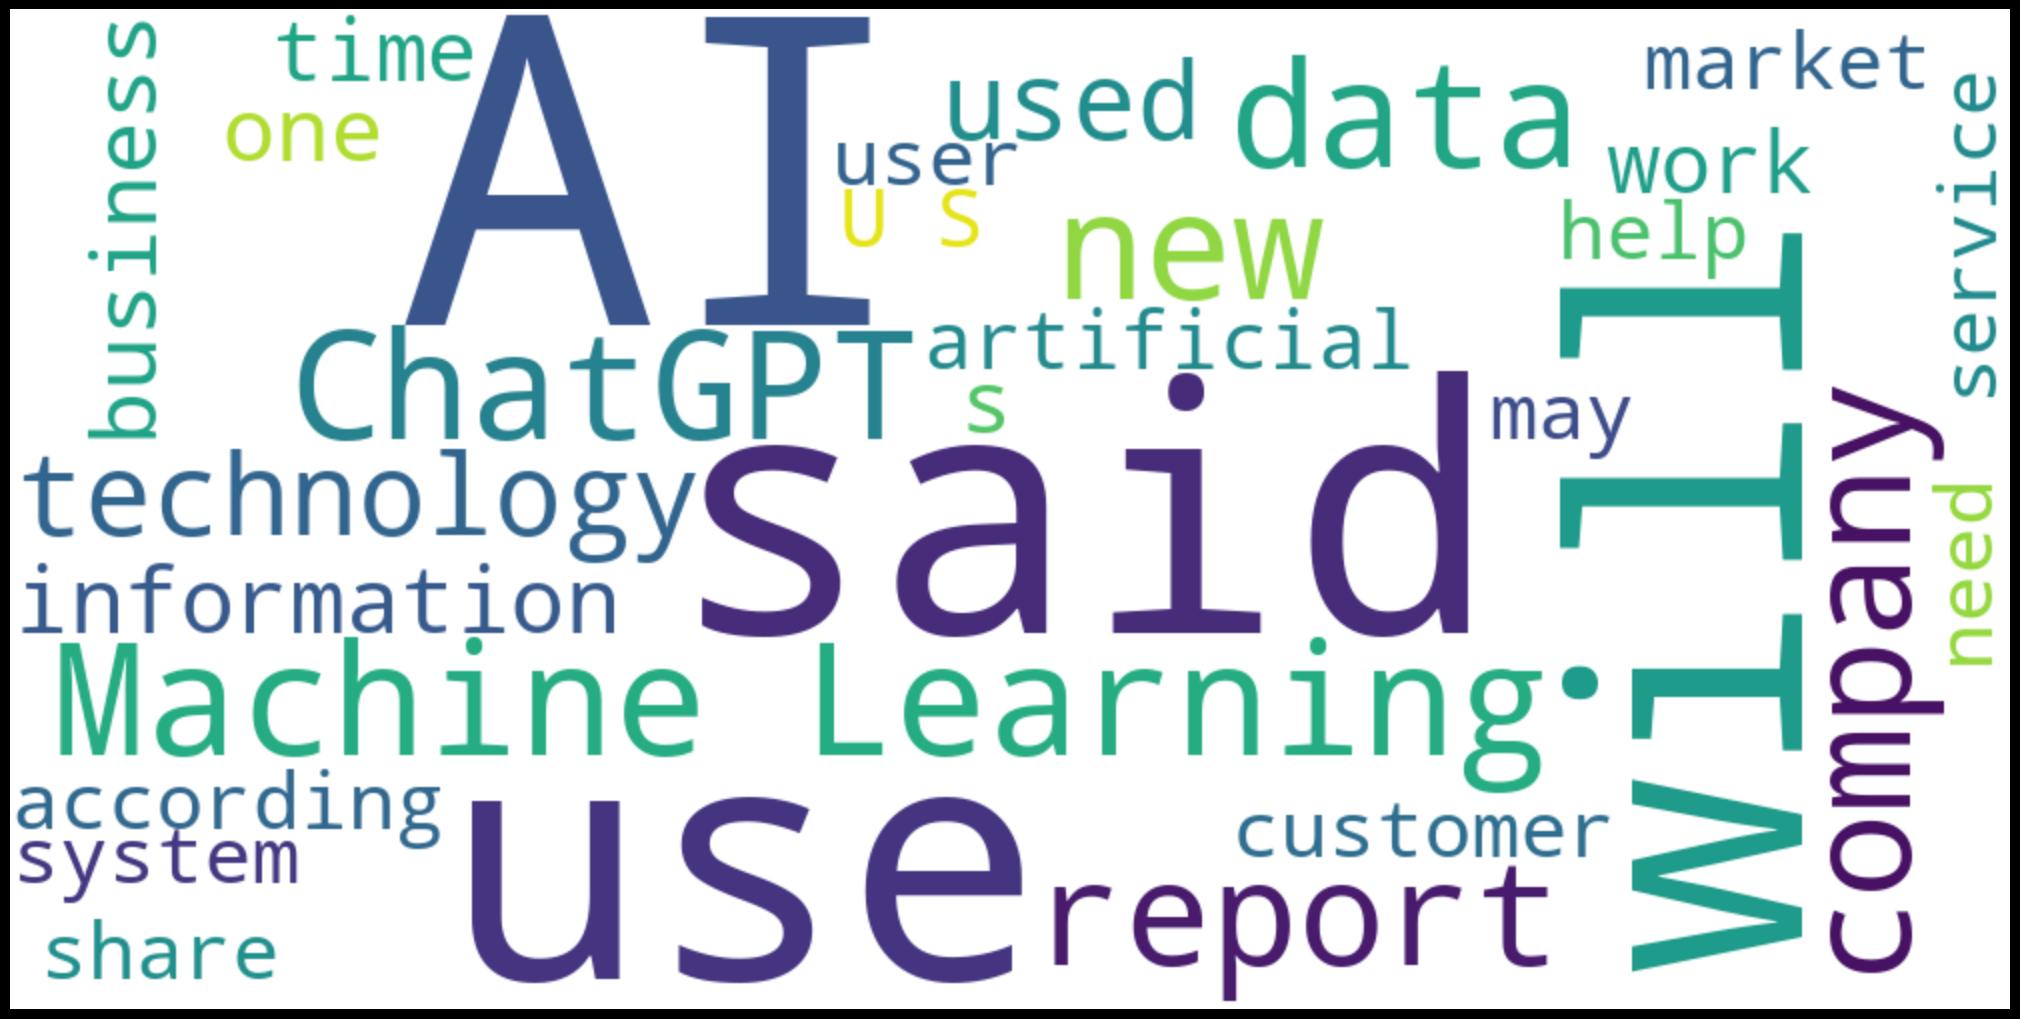

In [58]:
wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate(neg_text2)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [94]:
keyw2 = ['chatgpt', 'llm', 'artificial intelligence', 'openai', 'ai', 'machine learning']

In [95]:
def get_ml_keywords(text):
    global keyw2
    words = text
    total_count = 0
    for i in keyw2:
        occurance_count = words.count(i)
        total_count += occurance_count
    return total_count

In [96]:
df = pd.read_csv('df_news_with_sent.csv')

In [97]:
df.head(1)

url        date   
0  http://en.people.cn/n3/2021/0318/c90000-9830122.html  2021-03-18  \

                                                                      clean_title   
0  Artificial improves parking efficiency in Chinese cities People s Daily Online  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [98]:
%%time

df['keywords'] = df['token_text'].parallel_apply(get_ml_keywords)

CPU times: user 433 ms, sys: 12.5 s, total: 12.9 s
Wall time: 14.8 s


In [99]:
df.head(1)

url        date   
0  http://en.people.cn/n3/2021/0318/c90000-9830122.html  2021-03-18  \

                                                                      clean_title   
0  Artificial improves parking efficiency in Chinese cities People s Daily Online  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [100]:
df = df[df['keywords']>0]

In [106]:
# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [107]:
news_timeline_df = df.copy()[['date', 'year','month','sentiment']].set_index('date')

In [108]:
news_timeline_df[['year','month']].value_counts()

year  month
2023  4        15533
      3        15426
      2        13806
      1         9639
2021  11        5899
2022  6         5790
      7         5397
      9         5371
      8         4989
2021  10        4917
2022  11        4765
      12        4572
      10        4444
      5         4255
2021  12        3579
      4         3428
      3         3299
      2         3258
2022  1         3227
2021  6         3219
2020  11        3190
2022  2         3026
      3         2999
2020  12        2983
      10        2874
      3         2734
2021  8         2728
2020  1         2692
2021  1         2653
      5         2592
2020  4         2564
      5         2549
2021  7         2538
2022  4         2521
2020  9         2472
2021  9         2423
2020  2         2418
      8         2097
      7         2011
      6         1699
Name: count, dtype: int64

In [109]:
news_timeline_df['year'].value_counts()

year
2023    54404
2022    51356
2021    40533
2020    30283
Name: count, dtype: int64

In [110]:
news_timeline_df.groupby('year').agg({'sentiment': 'mean'})

,sentiment
year,
2020,0.301495
2021,0.313512
2022,0.312907
2023,0.281707


<AxesSubplot: xlabel='month', ylabel='sentiment'>

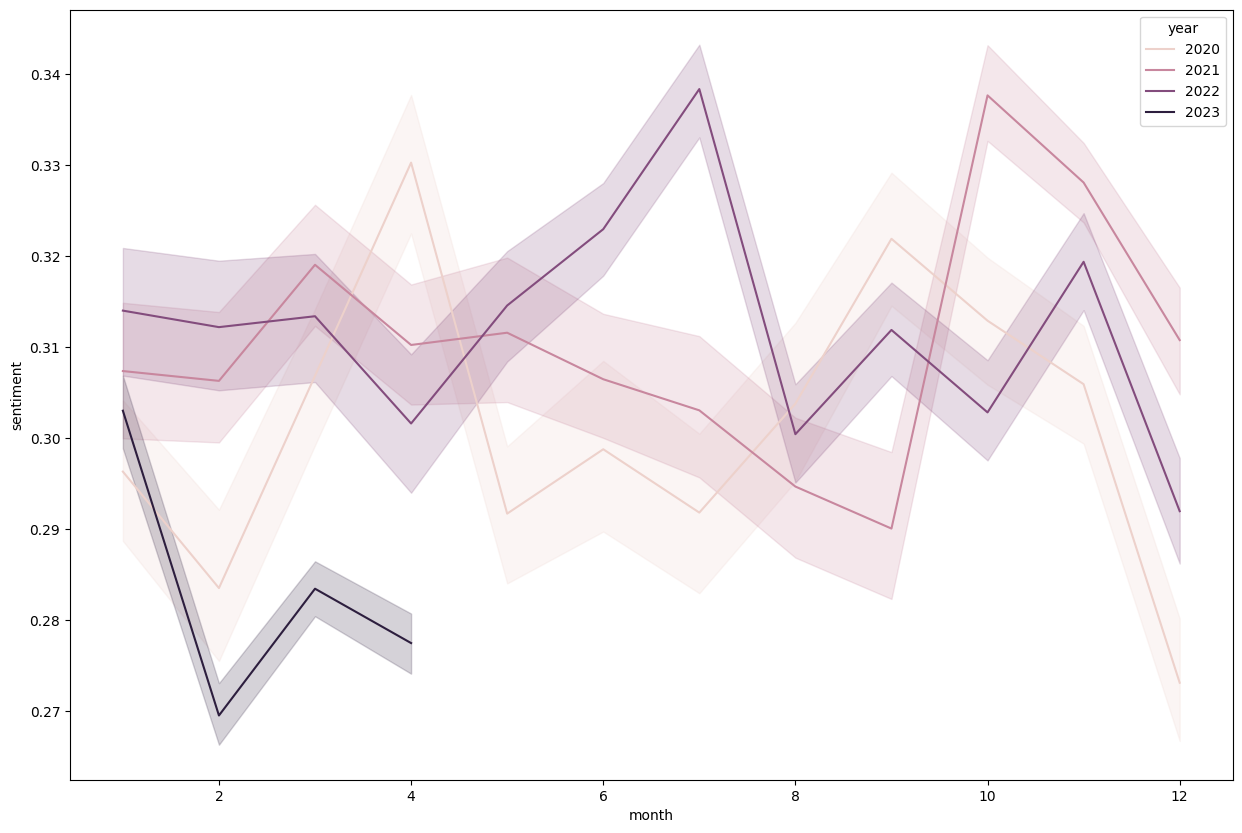

In [111]:
plt.rcParams["figure.figsize"] = (15,10)
sns.lineplot(x='month',y='sentiment',hue='year',data=news_timeline_df)